In [1]:
import torch
import torch.nn as nn
import math
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch.optim as optim
from nltk.translate.bleu_score import corpus_bleu
from IPython.display import clear_output
import torch.nn.functional as F
from tqdm import tqdm, trange
from PIL import Image

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
regex = r"\b[\w-]+\b"

In [2]:
from google.colab import drive
drive.mount('/content/drive')
way = "/content/drive/MyDrive/Colab_Notebooks/aaa_ml/datasets/"

Mounted at /content/drive


Класс перенесен сюда

In [3]:
import sys
import numpy as np
import torch
import torch.nn.functional as F

class Vocab:
    def __init__(self, tokens, bos="_BOS_", eos="_EOS_", unk='_UNK_'):
        """
        A special class that converts lines of tokens into matrices and backwards
        """
        assert all(tok in tokens for tok in (bos, eos, unk))
        self.tokens = tokens
        self.token_to_ix = {t:i for i, t in enumerate(tokens)}
        self.bos, self.eos, self.unk = bos, eos, unk
        self.bos_ix = self.token_to_ix[bos]
        self.eos_ix = self.token_to_ix[eos]
        self.unk_ix = self.token_to_ix[unk]

    def __len__(self):
        return len(self.tokens)

    @staticmethod
    def from_lines(lines, bos="_BOS_", eos="_EOS_", unk='_UNK_'):
        flat_lines = '\n'.join(list(lines)).split()
        tokens = sorted(set(flat_lines))
        tokens = [t for t in tokens if t not in (bos, eos, unk) and len(t)]
        tokens = [bos, eos, unk] + tokens
        return Vocab(tokens, bos, eos, unk)

    def tokenize(self, string):
        """converts string to a list of tokens"""
        tokens = [tok if tok in self.token_to_ix else self.unk
                  for tok in string.split()]
        return [self.bos] + tokens + [self.eos]

    def to_matrix(self, lines, dtype=torch.int64, max_len=None):
        """
        convert variable length token sequences into  fixed size matrix
        example usage:
        >>>print(to_matrix(words[:3],source_to_ix))
        [[15 22 21 28 27 13 -1 -1 -1 -1 -1]
         [30 21 15 15 21 14 28 27 13 -1 -1]
         [25 37 31 34 21 20 37 21 28 19 13]]
        """
        lines = list(map(self.tokenize, lines))
        max_len = max_len or max(map(len, lines))

        matrix = torch.full((len(lines), max_len), self.eos_ix, dtype=dtype)
        for i, seq in enumerate(lines):
            row_ix = list(map(self.token_to_ix.get, seq))[:max_len]
            matrix[i, :len(row_ix)] = torch.as_tensor(row_ix)

        return matrix

    def to_lines(self, matrix, crop=True):
        """
        Convert matrix of token ids into strings
        :param matrix: matrix of tokens of int32, shape=[batch,time]
        :param crop: if True, crops BOS and EOS from line
        :return:
        """
        lines = []
        for line_ix in map(list, matrix):
            if crop:
                if line_ix[0] == self.bos_ix:
                    line_ix = line_ix[1:]
                if self.eos_ix in line_ix:
                    line_ix = line_ix[:line_ix.index(self.eos_ix)]
            line = ' '.join(self.tokens[i] for i in line_ix)
            lines.append(line)
        return lines

    def compute_mask(self, input_ix):
        """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
        return F.pad(torch.cumsum(input_ix == self.eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)



# Перевод предложений с английского на русский

- В этом задании предлагается реализовать модель, которая будет автоматически переводить предложения с английского языка на русский;
- Реальные модели перевода учатся на больших корпусах много GPU часов. Чтобы вычислительные ресурсы не были препятствием в этом задании, вам дан датасет с простой лексикой и не очень длинными предложениями;
- Всего в датасете 22550 пар предложений на английском и русском языке, некоторые предложения повторяются;
- При правильном выполнении всех заданий вы получите модель, принимающую на вход предложение на английском языке и выдающую его перевод на русский.

## Данные

In [4]:
data = pd.read_csv(way + 'eng_ru_pairs.tsv', sep='\t', header=0, names=['eng', 'ru'])
data.head()

,eng,ru
0,I can only wonder if this is the same for ever...,"Я могу только догадываться, так ли это и для в..."
1,The last person I told my idea to thought I wa...,"Последний человек, которому я рассказал свою и..."
2,I've always wondered what it'd be like to have...,"Мне всегда было интересно, как это - иметь бра..."
3,It would take forever for me to explain everyt...,"Мне потребовалась бы вечность, чтобы всё объяс..."
4,"Back in high school, I got up at 6 a.m. every ...","Когда я учился в средней школе, я вставал в 6:..."


In [5]:
# Отделим 20% пар перевода на валидацию
train_input, val_input, train_output, val_output = train_test_split(data.eng, data.ru, test_size=0.2, random_state=1)

In [6]:
# Распределение длин предложений на английском языке
train_input.apply(len).describe()

count    18040.000000
mean        54.282761
std          2.541159
min         51.000000
25%         52.000000
50%         54.000000
75%         56.000000
max         59.000000
Name: eng, dtype: float64

In [7]:
# Распределение длин предложений на русском языке
train_output.apply(len).describe()

count    18040.000000
mean        51.376330
std          9.986654
min         15.000000
25%         45.000000
50%         51.000000
75%         58.000000
max        101.000000
Name: ru, dtype: float64

## Метрика качества перевода

Для оценки качества автоматического перевода используется метрика [BLEU SCORE](https://en.wikipedia.org/wiki/BLEU). Можно описать, что эта метрика считает:

1) Точность по совпадению n-грам
2) Штрафует за короткие ответы

Метрика задаётся формулой:
$$BLEU = BP * exp(\sum_{n}w_n  log(p_n))$$

BP — штраф за краткость (Brevity Penalty), который накладывается на слишком короткие предсказания. Вычисляется как:

$$BP = \left\{\begin{matrix}
 1,\ если\ c > r\\
 exp(1 - r/c),\ если\ c \le r\\
\end{matrix}\right.$$

Здесь c — длина предсказанных последовательностей, а r — длина эталонных последовательностей.

- $w_n$ — вес каждой n-граммы (обычно используется равномерное распределение весов).
- $p_n$ — точность n-грамм, которая вычисляется как отношение количества совпадающих n-грамм в предсказании и эталоне к общему количеству n-грамм в предсказании.
- $\sum_{n}w_n  log(p_n)$ — средневзвешенная сумма логарифмов точностей n-грамм (обычно от 1 до 4).


[Ссылка на оригинальную статью.](https://aclanthology.org/P02-1040.pdf)

In [8]:
from nltk.translate.bleu_score import corpus_bleu

# y_hat - корпус с предсказаниями модели (машинный перевод),
# y - корпус с эталонными переводами.
# Обратите внимание, что каждый предсказанный перевод и соответствующий ему эталонный перевод
# должны быть представлены в виде списка токенизированных слов.

y_hat = [['This', 'is', 'a', 'test'], ['Another', 'test']]
y = [[['This', 'is', 'a', 'test']], [['Another', 'one']]] # на один y_hat может быть несколько y (эталонных переводов)

# Вычисление BLEU score
score = corpus_bleu(y, y_hat)

print(f"BLEU score: {score}")

BLEU score: 0.6756000774035172


## Токенизация

- Подавать текст в модель напрямую невозможно, поэтому его нужно токенизировать. Существует множество способов токенизировать текст, для решения этой задачи мы будем использовать самый простой: разделять предложения на токены по пробелу. Чтобы не отвлекаться на реализацию такого токенайзера, можно пользоваться готовым классом Vocab;
- Для обучения трансформеров чаще всего используются другие, более продвинутые методы токенизации, например, [bpe](https://en.wikipedia.org/wiki/Byte_pair_encoding) или [sentence pieces](https://github.com/google/sentencepiece);
- Не вдаваясь в подробности, можно сказать, что указанные выше методы токенизации основаны на совстречаемости символов и (условно) обучаются на больших корпусах, чтобы учесть статистику совстречаемости при составлении словаря. Так, очень частые сочетания букв языка, на котором обучался словарь, будут кодироваться одним токеном, а редкие сочетания кодироваться отдельными токенами каждого символа. Давайте в этом убедимся.

Для обучения понадобится два токенайзера: первый для токенизации английского, будет использоваться в энкодере, второй для русского, использоваться будет в декодере.

In [9]:
encoder_tokenizer = Vocab.from_lines(data.eng)  # составим словарь для английского на всём датасете
decoder_tokenizer = Vocab.from_lines(data.ru)  # составим словарь для русского на всём датасете

Опишем основные атрибуты токенайзера

In [10]:
encoder_tokenizer.bos_ix  # индекс начала последовательности
encoder_tokenizer.eos_ix  # индекс конца последовательности (этот же индекс используется для паддинга)
encoder_tokenizer.to_matrix  # получить torch.tensor с id токенов из списка текстов

len(encoder_tokenizer.tokens)  # количество токенов в словаре энкодера и декодера

17563

In [11]:
encoder_tokenizer.to_matrix(['test tokenizer', 'test'])  # подробнее посмотрим на работу токенайзера,
                                                         # обратите внимание на паддинг второй последовательности
                                                         # в словаре нет слова "tokenizer", индекс неизвестного слова – 2

tensor([[    0, 15851,     2,     1],
        [    0, 15851,     1,     1]])

---

## Позиционное кодирование

<div style="text-align: center; margin-left: 70px;">
    <img src="images/positional_embedings.png" alt="alt text" width="500" height="500"/>
</div>
<figcaption style="text-align: center;"></figcaption>




В задачах обработки последовательности относительный порядок токенов чрезвычайно важен. При обучении RNN данные подаются и обрабатываются в модели последовательно, соответсвенно взаимное расположение токенов учитывается само по себе за счёт архитектуры.

Однако, когда вы обучаете Transformer с использованием self attention, токены обрабатываются параллельно. Хотя это значительно сокращает время обучения, информация о расположении токенов друг относительно друга отсутствует. Чтобы это исправить используется позиционное кодирование (positional encoding). Мы можем сгенерировать необучаемые эмбединги, которые в компонентах своих векторов будут содержать информацию о позиции токена в последовательности. Затем эти эмбединги добавляются к исходным эмбедингам и модель адаптируется к добавленной информации во время обучения.



$$
PE_{(pos, 2i)}= sin\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
\tag{1}$$

$$
PE_{(pos, 2i+1)}= cos\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
\tag{2}$$

Две формулы сверху задают вычисление чётных (1) и нечётных (2) компонент векторов позиционного кодирования.

Вместо возведения 10000 в степень мы будем использовать более стабильную версию этого выражения:
$${div\_term} = \frac{1}{10000^\frac{2i}{d}} = \exp\left(-\frac{2i\cdot \log(10000)}{d_{\text{model}}}\right)$$


- $d$ — размерность вектора слов и позиционного кодирования;
- $pos$ — позиция слова;
- $i$ номер компоненты вектора, для которой вычисляется значение. Для чётных компонент вычисляется синус, для нечётных косинус.

Авторы статьи утверждают, что выбрали именно эти функции, так как предположили, что модель будет легко учиться ориентироваться в относительных позициях токенов, так как любой сдвиг на k токенов выражается как линейная комбинация синусов и косинусов $sin(x+k)=sin(x)cos(k)+cos(x)sin(k)$.

Если же просто закодировать позиции, добавив матрицу из единиц или целых чисел к вектору слов, семантическое значение искажается. Напротив, значения синуса и косинуса так малы (между -1 и 1), что добавляя позиционное кодирование к вектору слов, он не искажается существенно, а обогащается информацией о позиции.

---

## Задание 1.


Реализуйте класс PositionalEncoding, инициализируемый двумя параметрами:
1) `d_model` (размерность эмбедингов);
2) `max_seq_length` (максимальная длина входной последовательности)

Основа класса реализована за вас, вам необходимо релизовать:
1) Нулевую матрицу `pe` для последующего заполнения
2) Переменную position, содержащую значения от 0 до `max_seq_length` - 1, размера (`max_seq_length`, 1)
3) Заполнить матрицу `pe`, используя `div_term` и проведя соответсвующие вычисления c формулами (1) и (2)
4) Реализовать метод forward у слоя позиционных эмбедингов, прибавив их к входной матрице

In [12]:
import torch
import torch.nn as nn
import numpy as np
import os
import random
import math


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        assert d_model % 2 == 0, 'Размерность эмбедингов должна быть чётной'

        # Инициализируем матрицу нулей (max_seq_length, d_model), в которой будут храниться значения позиционных эмбедингов
        pe = torch.zeros(max_seq_length, d_model)

        # Создайте переменную position (), равную длине последовательности и содержащую соответствующие значения (~1 строка кода)
        position = torch.arange(max_seq_length, dtype=torch.float).unsqueeze(1)

        # Переменная div_term содержит стабильную версию вычисления 1/(10000)**(2i/d_model), то есть всего того, что находится
        # в числителе для чётной и нечётной позиции эмбединга.
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        # Используйте переменную div_term для вычисления (~2 строки кода)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe) # добавляем доп размерность и указываем что эти параметры
                                                    # не буду оубчающимися


    def forward(self, x):
        """
        Вычисляет сумму входных и позиционных эмбедингов

        Arguments:
            x (batch_size, position, d_model) -- Maximum number of positions to be encoded

        Returns:
            x -- (batch_size, position, d_model) Матрицу
        """
        # Вычислите сумму входных эмбедингов и позиционного кодирования (~1 строка кода)
        x = x + self.pe[:, :x.size(1)]
        return x

In [13]:
test_input = torch.tensor(
    [[-1, 2,3, 0],
     [2, 3, 3, 0],
     [100, 0, 3, 0],
]).unsqueeze(0)
test_maxs_seq_len = 10
test_d_model = 4

expected = torch.tensor([[
         [ -1.0000,   3.0000,   3.0000,   1.0000],
         [  2.8415,   3.5403,   3.0100,   0.9999],
         [100.9093,  -0.4161,   3.0200,   0.9998]]]
)

pe = PositionalEncoding(test_d_model, test_maxs_seq_len)
assert expected.shape == pe(test_input).shape, f'Размерности не совпадают: {expected.shape} vs {pe(test_input).shape}'
assert np.allclose(expected.numpy(), pe(test_input).numpy(), rtol=1e-04, atol=1e-4), 'Значения не совпадают, проверь формулу!'
print('Поздравляем, тесты пройдены!')

Поздравляем, тесты пройдены!


Давайте визуализируем получившиееся значния для нечётных индексов. В компонентах от 0 до 50 значения часто меняются от -1 до 1, а период изменения значения для компоненты под номером 150 гораздо больший, примерно 2 раза за всю последовательность из 2048 позиций.

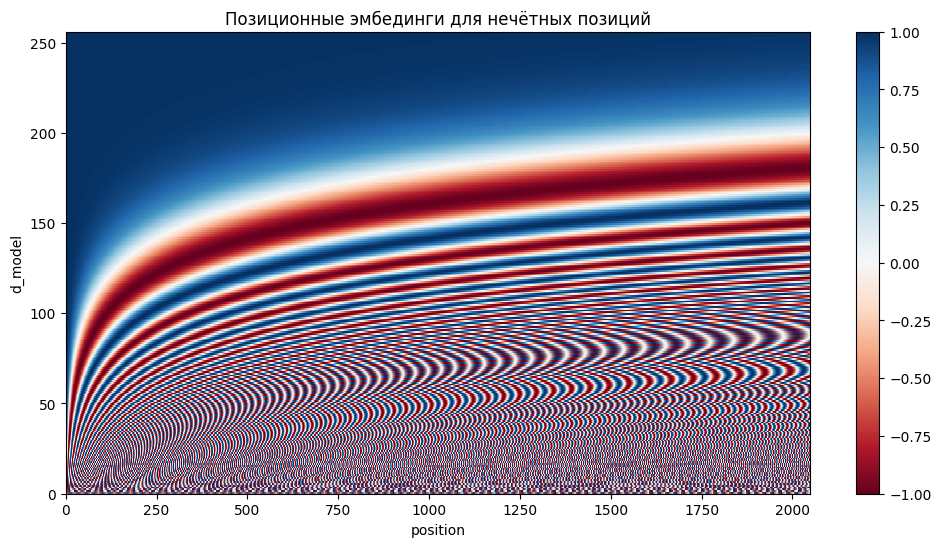

In [14]:
pos_encoding = PositionalEncoding(d_model=512, max_seq_length=2048)
pos_embeddings = pos_encoding(torch.zeros((1, 2048, 512)))
plt.figure(figsize=(12, 6))
plt.pcolormesh(pos_embeddings[0][:, 1::2].numpy().T, cmap='RdBu')
plt.ylabel('d_model')
plt.xlabel('position')
plt.title('Позиционные эмбединги для нечётных позиций')
plt.colorbar()
plt.show();

## Multihead attention

Вместо того, чтобы на одном слое self attention вычислять только один набор больших матриц Q, K, V рамерности $d_{model}$, предлагается учить несколько голов размерности $d_{model}\ //\ num\_heads$, а затем конкатенировать их с последующим умножением на $W^O$.

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h)W^O
$$

где каждая голова вычисляется, как:

$$
\text{head}_i = \text{Attention}(QW^Q_i, KW^K_i, VW^V_i)
$$

Авторы архитектуры обнаружили, что это не только улучшает вычислительную эффективность, но и увеличивает выразительность векторных представлений, получающихся в результате обучения.

In [15]:
def image_from_driver(str, label):

  image_path = way + str
  image = Image.open(image_path)
  fig, ax = plt.subplots(figsize=(10, 8))
  ax.set_title(label)
  ax.imshow(image)
  ax.axis('off')
  plt.show()

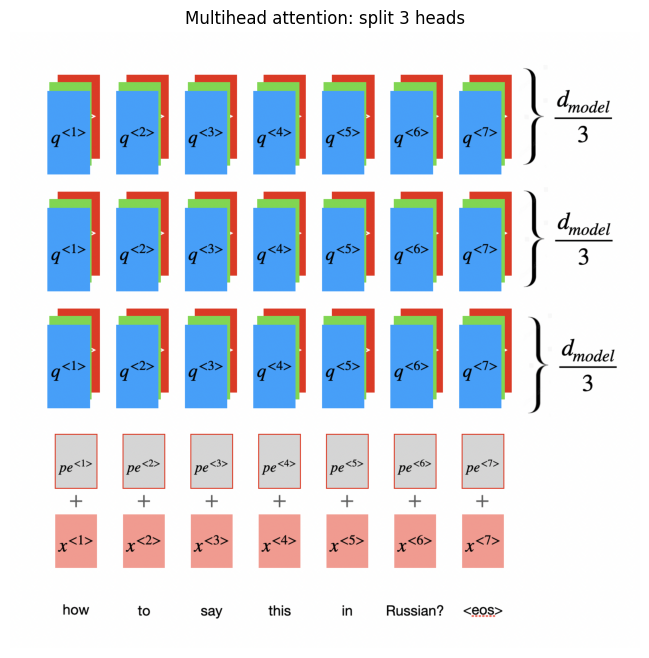

In [16]:
image_from_driver('images/multihead_attention_split.png', "Multihead attention: split 3 heads")

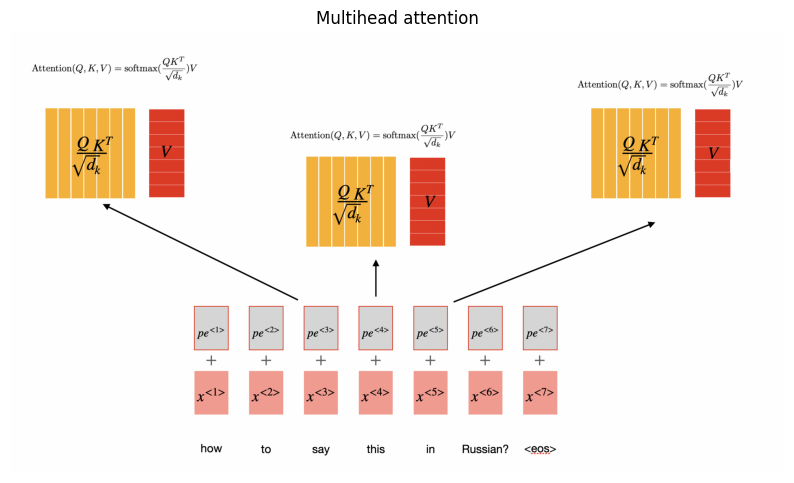

In [17]:
image_from_driver('images/multihead_attention_qkv.png', "Multihead attention")

### Задание

Настало время реализовать сердце модели трансформер: MultiHeadAttention.


В этом слое вам необходимо:

1. Инициализировать матрицы `W_q`, `W_k`, `W_v` – матрицы для преобразования входных (в слой) эмбеддингов к соответсвующим эмбедингам Q, K и V. Мы будем инициализировать изначально сконкатенированные по головам матрицы, то есть их размерность равна (d_model, d_model). Также, при инициализации класса, необходимо инициализировать матрицу выходной проекции `W_o`.
2. Реализовать scaled_dot_product_attention, слой производящий вычисления для self attention. Этот слой принимает на вход Q, K, V, применяет необходимую маску: в случае энкодера это только маска паддинга, в случае декодера ещё и маска, гарантирующая недоступность будущих токенов для механизма внимания (casual_mask). Далее происходит нормализация и последующее перевзвешивание (суммирование с весами исходных V).
   Эта функция должна реализовать знаменитую формулу:
$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\tag{4}\
$$

* $Q$ матрица queries
* $K$ матрица keys
* $V$ матрица values
* $M$ опциональная матрица маски
* ${d_k}$ размерность keys, для нормирования матричного перемножения

3. Реализовать `forward` метод для слоя MultiHeadAttention.

In [18]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Размерность модели должна нацело делиться на количество голов
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        # Инициализируйте переменные
        self.d_model = d_model # Размерность слоя (определяет размерность Q, K, V)
        self.num_heads = num_heads # Количество голов
        self.d_k = d_model // num_heads # Размерность одного слоя self-attention

        # Инициализируйте линейные слои для преобразования входных данных (d_model, d_model)
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Вычислите веса self.attention. Q и K размерности (batch_size, num_heads, seq_length, d_k),
        # поэтому транспонирование для K нужно проводить по последним двум осям, используйте .transpose(-2, -1)
        # (~1 строка кода)
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Если в метод передали переменную mask, используйте её чтобы заполнить 0 в матрице маски, значениями -1e9.
        # Используйте torch.masked_fill чтобы выполнить это задание.
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, float('-1e9'))

        # Примените softmax нормализацию для весов внимания (~1 строка кода)
        attn_probs = F.softmax(attn_scores, dim=-1)

        # Вычислите выход из функции, с применением весов внимания к V
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        # Изменение формы входной последовательность (Q, K или V) на несколько голов
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        # Соединение нескольких голов внимания обратно в эмбеддинги размерности d_model
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        # Примените линейное преобразование к входным матрицам Q, K, V
        # (~3 строчки кода)
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        # Примените слой self-attention, не забудьте передать маску (~1 строка кода)

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)

        # Примените выходное преобразование с помощью матрицы W_o
        # и объединения выхода self-attention с помощью функции .combine_heads
        # (~1 строчки кода)
        attn_output = self.combine_heads(attn_output)
        output = self.W_o(attn_output)
        return output

In [19]:
# Инициализация модели MultiHeadAttention
test_d_model = 64  # размерность модели
test_num_heads = 4  # количество голов
test_seq_length = 10  # длина последовательности
test_batch_size = 2  # размер батча

test_model = MultiHeadAttention(test_d_model, test_num_heads)

# Создание тестовых данных
test_Q = torch.rand(test_batch_size, test_seq_length, test_d_model)  # Случайные данные для queries
test_K = torch.rand(test_batch_size, test_seq_length, test_d_model)  # Случайные данные для keys
test_V = torch.rand(test_batch_size, test_seq_length, test_d_model)  # Случайные данные для values

# Маска для проверки механизма маскирования
test_mask = (torch.randn(test_batch_size, test_seq_length, test_seq_length) > 0).unsqueeze(1)

# Прогоняем данные через модель
test_output = test_model(test_Q, test_K, test_V, mask=test_mask)

# Проверяем размеры выходных данных
print("Output shape:", test_output.shape)  # Ожидаемый размер: [batch_size, seq_length, d_model]

# Проверка отдельных функций
# Прогоняем через scaled_dot_product_attention
attention_output = test_model.scaled_dot_product_attention(test_Q, test_K, test_V, mask=test_mask)
print("Attention Output shape:", attention_output.shape)

# Проверка преобразования входных данных
transformed_q = test_model.W_q(test_Q)
transformed_k = test_model.W_k(test_K)
transformed_v = test_model.W_v(test_V)
print("Transformed Q shape:", transformed_q.shape)
print("Transformed K shape:", transformed_k.shape)
print("Transformed V shape:", transformed_v.shape)

# Проверка работы функций split_heads и combine_heads
split_Q = test_model.split_heads(test_Q)
combined_Q = test_model.combine_heads(split_Q)
print("Split Q shape:", split_Q.shape)
print("Combined Q shape after split and combine:", combined_Q.shape)

print('\nПоздравляем, тесты пройдены!')

Output shape: torch.Size([2, 10, 64])
Attention Output shape: torch.Size([2, 2, 10, 64])
Transformed Q shape: torch.Size([2, 10, 64])
Transformed K shape: torch.Size([2, 10, 64])
Transformed V shape: torch.Size([2, 10, 64])
Split Q shape: torch.Size([2, 4, 10, 16])
Combined Q shape after split and combine: torch.Size([2, 10, 64])

Поздравляем, тесты пройдены!


## Последние нюансы!

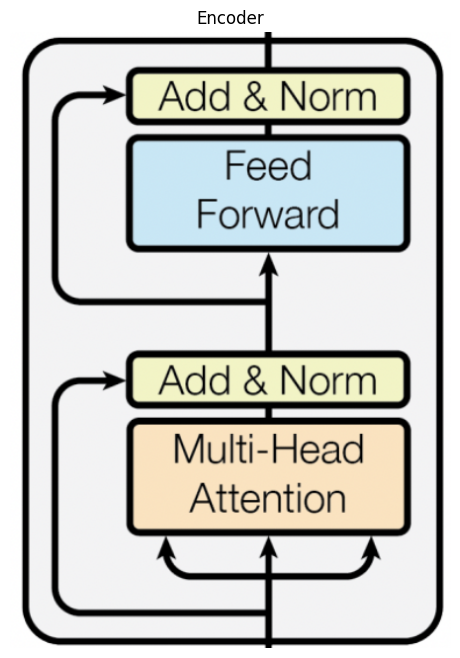

In [20]:
image_from_driver('images/encoder.png', "Encoder")

Теперь, когда мы реализовали основной слой трансформера, осталось совсем немного!

Реализуем EncoderLayer совсем как на картинке:


1. Используйте  nn.Linear, nn.ReLU, nn.LayerNorm, nn.Dropout для реализации
2. Skip Connection реализуется простым сложением

In [21]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        # Инициализируейте веса первого линейного слоя выходной размерностью d_ff (~1 строка кода)
        self.fc1 = nn.Linear(d_model, d_ff)
        # Инициализируейте веса второго линейного слоя выходной размерностью d_model (~1 строка кода)
        self.fc2 = nn.Linear(d_ff, d_model)
        # Задайте переменную с функцией активации relu (~1 строка кода)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Примените первый линейной слой, активацию и второй линейный слой (~1-3 строки кода)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [22]:
# TODO тесты на правильность значений

# Инициализация модели PositionWiseFeedForward
test_d_model = 64  # размерность модели
test_d_ff = 256    # размерность скрытого слоя

test_model = PositionWiseFeedForward(test_d_model, test_d_ff)

# Создание тестового тензора
test_batch_size = 2  # размер батча
test_seq_length = 10  # длина последовательности

# Создаем тестовый тензор с размером соответствующим входным данным модели
test_x = torch.rand(test_batch_size, test_seq_length, test_d_model)

# Прогоняем тестовый тензор через модель
test_output = test_model(test_x)

# Проверяем размеры выходных данных
print("Output shape:", test_output.shape)  # Ожидаемый размер: [batch_size, seq_length, d_model]

# Проверка наличия функции активации ReLU между слоями
# Применяем первый линейный слой и функцию активации к тестовым данным
test_activated_output = test_model.relu(test_model.fc1(test_x))
print("Activated output after first layer shape:", test_activated_output.shape)  # Ожидаемый размер: [batch_size, seq_length, d_ff]

# Проверяем, что активация не содержит отрицательных значений (ReLU эффект)
print("Check no negative values in activated output:", torch.all(test_activated_output >= 0))

# Проверяем выходные данные второго слоя
test_final_output = test_model.fc2(test_activated_output)
print("Final output shape after second layer:", test_final_output.shape)  # Ожидаемый размер: [batch_size, seq_length, d_model]


Output shape: torch.Size([2, 10, 64])
Activated output after first layer shape: torch.Size([2, 10, 256])
Check no negative values in activated output: tensor(True)
Final output shape after second layer: torch.Size([2, 10, 64])


In [23]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        # Создайте слой MultiHeadAttention (~1 строка кода)
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        # feed_forward слой с нужными параметрами (~1 строка кода)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        # Инициализируйте первый слой LayerNorm (~1 строка кода)
        self.norm1 = nn.LayerNorm(d_model)
        # Инициализируйте первый слой LayerNorm (~1 строка кода)
        self.norm2 = nn.LayerNorm(d_model)
        # Инициализируйте слой Dropout (~1 строка кода)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        # Примените слой self attention к входным данным (~1 строка кода)
        attn_output = self.self_attn(x, x, x, mask)
        # К выходу из self attention примените дропаут,
        # затем прибавьте к входным данным, реализуя skip connection
        # и выполните нормализацию (~1-3 строки кода)
        x = x + self.dropout(attn_output)
        x = self.norm1(x)

        # Реализуйте полносвязный слой к выходу из нормализации (~1 строка кода)
        ff_output = self.feed_forward(x)

        # Реализуйте последовательное применение дропаута, skip connection и нормализации (~1-3 строки кода)
        x = x + self.dropout(ff_output)
        x = self.norm2(x)
        return x

In [24]:
# TODO тесты на правильность значений

# Инициализация слоя EncoderLayer
test_d_model = 64  # размерность модели
test_num_heads = 4  # количество голов в многоголовом внимании
test_d_ff = 256    # размерность скрытого слоя в feed-forward сети
test_dropout_rate = 0.1  # вероятность дропаута

test_encoder_layer = EncoderLayer(test_d_model, test_num_heads, test_d_ff, test_dropout_rate)

# Создание тестовых данных
test_batch_size = 2  # размер батча
test_seq_length = 10  # длина последовательности
test_x = torch.rand(test_batch_size, test_seq_length, test_d_model)  # случайные данные

# Маска для тестирования механизма маскирования (можно задать None для упрощения)
test_mask = None

# Прогоняем тестовые данные через encoder layer
test_output = test_encoder_layer(test_x, test_mask)

# Проверяем размеры выходных данных
print("Output shape:", test_output.shape)  # Ожидаемый размер: [test_batch_size, test_seq_length, test_d_model]


Output shape: torch.Size([2, 10, 64])


## Реализация Decoder Layer


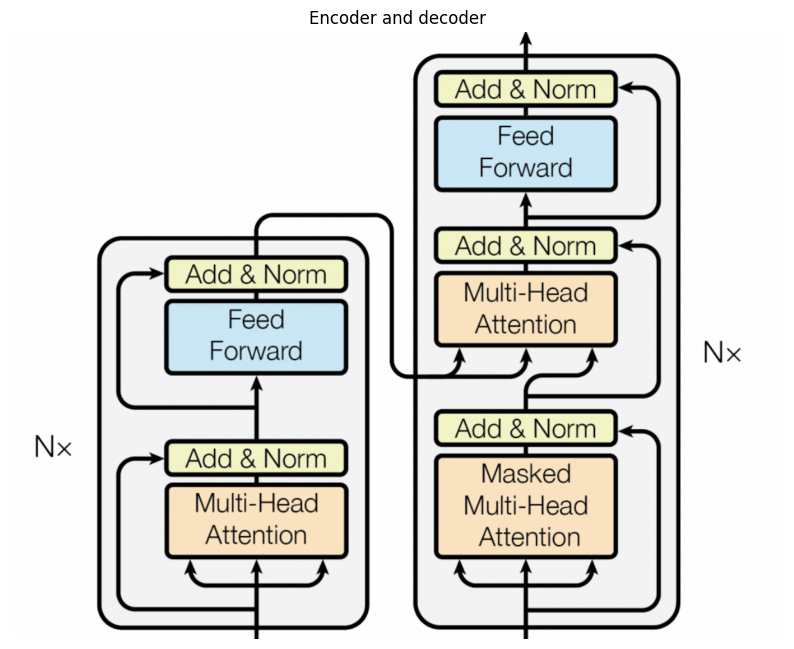

In [25]:
image_from_driver('images/encoder-decoder.png', "Encoder and decoder")


В декодере все слои делятся на два типа:
1) `self attention` cлой, в котором важно применять маску для весов внимания, предотвращающую "заглядывание" в будущее. Каждый новый эмбеддинг $v^{<t>}$ должен состоять из взвешанной суммы векторов от $1$ до $<t>$. На картинке этот слой обозначен как Masked Multi-Head Attention
2) `cross attenеtion` принимает на вход $Q$ из предыдущих слоёв декодера, а в качестве $K$ и $V$ берёт выход энкодера.

Остальные части декодера использовались в энкодере, поэтому они реализованы за вас.

In [26]:
def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

In [27]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        # Примените слой self attention к входным данным
        # используйте tgt_mask в качестве маски предотвращающей заглядывание в будущее (~1 строка кода)
        attn_output = self.self_attn(x, x, x, tgt_mask)

        # Примените слой дропаут, скип коннекшн и первую нормализацию к выходу из self attention (~1-3 строки кода)
        x = x + self.dropout(attn_output)
        x = self.norm1(x)

        # Примените слой cross_attn к выходу из предыдущего слоя и выходу из энкодера, используйте src_mask
        attn_output2 = self.cross_attn(x, enc_output, enc_output, src_mask)

        # Примените слой дропаут, скип коннекшн и вторую нормализацию к выходу из cross_attn (~1-3 строки кода)
        x = x + self.dropout(attn_output2)
        x = self.norm2(x)

        # feedforward слой (~1 строка кода)
        ff_output = self.feed_forward(x)

        # Примените слой дропаут, скип коннекшн и третью нормализацию к выходу из feed_forward (~1 строка кода)
        x = x + self.dropout(ff_output)
        x = self.norm3(x)
        return x

In [28]:
# Инициализация слоя DecoderLayer
test_d_model = 64  # размерность модели
test_num_heads = 4  # количество голов в многоголовом внимании
test_d_ff = 256    # размерность скрытого слоя в feed-forward сети
test_dropout_rate = 0.1  # вероятность дропаута

test_decoder_layer = DecoderLayer(test_d_model, test_num_heads, test_d_ff, test_dropout_rate)

# Создание тестовых данных для декодера
test_batch_size = 2  # размер батча
test_seq_length = 10  # длина последовательности
test_decoder_input = torch.rand(test_batch_size, test_seq_length, test_d_model)  # случайные данные для декодера

# Создание тестовых данных для энкодера (могут быть такими же, как данные для декодера)
test_encoder_output = torch.rand(test_batch_size, test_seq_length, test_d_model)  # случайные данные энкодера

# Тестовые маски
test_src_mask = (torch.randn(test_batch_size, 1, test_seq_length) > 0).unsqueeze(1)  # Маска источника
test_tgt_mask = (torch.randn(test_batch_size, test_seq_length, test_seq_length) > 0).unsqueeze(1)  # Маска цели

# Прогоняем тестовые данные через слой декодера
test_output = test_decoder_layer(test_decoder_input, test_encoder_output, test_src_mask, test_tgt_mask)

# Проверяем размеры выходных данных
print("Output shape:", test_output.shape)  # Ожидаемый размер: [test_batch_size, test_seq_length, test_d_model]



Output shape: torch.Size([2, 10, 64])


## Финишная прямая!



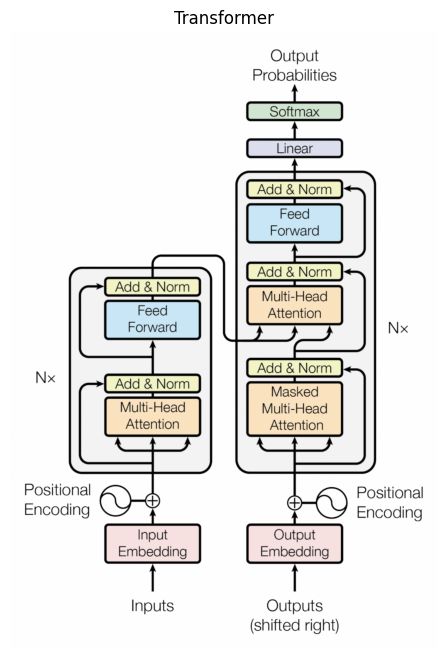

In [29]:
image_from_driver('images/transformer_orig_pic.png', "Transformer")

Теперь, наконец-то, из всех этих частей мы можем собрать свой трансформер! Кто бы мог подумать, что всего за каких-то... 1.5 часа? Мы смогли собственноручно написать одну из самых современных архитектур нейронных сетей!

Для этого нам нужно внимательно изучить картинку и нигде не ошибиться:

1) Создать слои входных эмбеддингов для энкодера и декодера. Мы собираемся переводить с одного языка на другой, вполне возможно, что эмбеддинги для этих языков будут разными (хотя иногда используют общие токенайзеры и как следствие общие входные эмбеддинги);
2) Инициализировать слои Mulit-Head Attention для энкодера и декодера;
3) Создать выходной линейный слой;
4) Реализовать корректную генерацию максок внимания для энкодера и декодера;
5) Реализовать forward.

In [37]:
class Transformer(nn.Module):
    def __init__(self,
                 src_vocab_size,
                 tgt_vocab_size,
                 d_model, num_heads,
                 num_layers,
                 d_ff,
                 max_seq_length,
                 dropout,
                 pad_token_id
        ):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        # Вставьте в ModuleList список из num_layers слоёв энкодера, аналогично для декодера (~2 строки кода)
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        # Инициализируйте выходной линейный слой  (~2 строки кода)
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.pad_token_id = pad_token_id

        self.softmax = nn.Softmax(dim=-1)

    def generate_mask(self, src, tgt):

        # Реализуйте bool маски для паддинга для входной последовательности энкодера (src_mask) и декодера
        # Все значения равные индексу токена паддинга должны быть равны False, остальные True (~2 строки кода)
        src_mask = (src != self.pad_token_id).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != self.pad_token_id).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)

        # Реализуйте bool маску для слоя внимания в декодере: nopeak_mask размерностью (1, seq_length, seq_length)
        # верхний треуголник получившейся матрицы должен состоять из нулей, все остальные значения равны 1
        # используйте torch.triu для реализации (~1 строка кода)
        nopeak_mask = ~torch.triu(torch.ones((1, seq_length, seq_length),
                     device=src.device), diagonal=1).byte()
        tgt_mask = tgt_mask & nopeak_mask

        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)

        # создайте эмбединги для src и tgt, посдедовательно применив слой эмбединга,
        # позиционного кодирования и дропаута (~2 строки кода)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        # Примените выходной линейный слой для предсказаний токенов на выхожде из декодера
        output = self.fc_out(dec_output)
        return output

In [38]:
import torch
import torch.nn as nn

# Предположим, что класс Transformer уже импортирован и содержит методы, описанные выше

# Создание экземпляра Transformer
test_model = Transformer(
    src_vocab_size=1000,   # размер словаря исходного языка
    tgt_vocab_size=1000,   # размер словаря целевого языка
    d_model=512,           # размерность векторов в модели
    num_heads=8,           # количество голов в механизме внимания
    num_layers=6,          # количество слоёв энкодера/декодера
    d_ff=2048,             # размерность скрытого слоя в FFN
    max_seq_length=100,    # максимальная длина последовательности
    dropout=0.1,           # вероятность дропаута
    pad_token_id=0         # индекс токена паддинга
).to(device)

# Инициализация тестовых данных
test_batch_size = 2
test_src_seq_length = 10
test_tgt_seq_length = 10
test_src = torch.randint(1, 1000, (test_batch_size, test_src_seq_length)).to(device)
test_tgt = torch.randint(1, 1000, (test_batch_size, test_tgt_seq_length)).to(device)

# Установка токенов паддинга для проверки маски
test_src[0, 8:] = 0  # добавляем паддинг в конец первого примера
test_tgt[1, 7:] = 0  # добавляем паддинг в конец второго примера

# Вызов функции для генерации масок
test_src_mask, test_tgt_mask = test_model.generate_mask(test_src, test_tgt)

# Проверяем корректность размеров масок
assert test_src_mask.shape == (test_batch_size, 1, 1, test_src_seq_length), "Incorrect src mask shape"
assert test_tgt_mask.shape == (test_batch_size, 1, test_tgt_seq_length, test_tgt_seq_length), "Incorrect tgt mask shape"

# Проверка значений масок (просто для печати)
print("Source Mask:\n", test_src_mask)
print("Target Mask:\n", test_tgt_mask)

# Прогоняем тестовые данные через модель
test_output = test_model(test_src, test_tgt)
print("Output shape:", test_output.shape)  # Ожидаемый размер: [test_batch_size, test_tgt_seq_length, tgt_vocab_size]

# Проверка корректности вывода
assert test_output.shape == (test_batch_size, test_tgt_seq_length, 1000), "Output shape is incorrect"


Source Mask:
 tensor([[[[ True,  True,  True,  True,  True,  True,  True,  True, False, False]]],


        [[[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]]]])
Target Mask:
 tensor([[[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

## Обучаем модель (домашнее задание)

В качестве домашнего задания предлагается обучить трансформер для перевода текстов на предоставленном датасете и реализовать модель инференса, чтобы оценить результат применения модели.

Для этого:
1. Неоходимо реализовать функцию вычисления loss: рассчитывать лосс с учётом сгенерённых масок.
2. Правильно подать данные для обучения: не забыть, что в декодер данные целевой последовательности подаются со смещением на один токен. На вход декодеру нужно подать последовательность `[_BOS_, token1, token2]`, а на выходе ожидать `[token1, token2, _EOS_]`.
3. Реализовать модель инференса Translator. Эта модель должна уметь генерировать перевод текста, принимая на вход только текст на английском языке.

Для расчёта масок для лосс функции можно воспользоваться функциями, встроенными в классы словаря. Нам потребуются:

`encoder_tokenizer.compute_mask()`

`decoder_tokenizer.compute_mask()`

`decoder_tokenizer.tokens`

In [39]:
def compute_loss(model, input, output, **flags):
    """
    Arguments:
        input: матрица входных токенов (batch, input_seq_len)
        out: матрица выходных токенов  (batch, output_seq_len)
    """
    # Выполните смещение на 1 токен для целевой последовательности декодера
    # и смещение на 1 токен для входных данных для декодера
    decoder_targets = output[:, 1:] #YOUR CODE HERE
    decoder_input = output[:, :-1]

    # Вычислите маску для ответов декодера (batch_size, input_seq_len-1) с помощью .compute_mask() декодера
    mask = decoder_tokenizer.compute_mask(decoder_input)

    targets_1hot = F.one_hot(decoder_targets, len(decoder_tokenizer.tokens)).to(torch.float32)

    # Предсказание модели (batch_size, output_seq_len-1, num_tokens)
    logits = model(input, decoder_input)

    # Логиты of all tokens at all steps, (batch_size, output_seq_len-1, num_tokens)
    log_prob = F.log_softmax(logits, dim=2)

    # Логиты правильных ответов (batch_size, out_len)
    logp_out = (log_prob * targets_1hot).sum(dim=-1)

    # Усредняем cross-entropy где mask == True
    return -torch.sum((logp_out * mask).sum(dim=-1)) / torch.sum(mask) # average loss, scalar

## Translator

<div style="text-align: center; margin-left: 70px;">
    <img src="images/inference.png" alt="alt text" width="500" height="500"/>
</div>
<figcaption style="text-align: center; ">Инференс первого токена с помощью трансформера</figcaption>

-------

Реализуйте класс Translator способный с помощью модели переводить тексты:
1. На вход ему подаются тесты на найглийском, происходит их токенезация;
2. В цикле генерируются токены на языке перевода, начиная с `_BOS_` токена.


In [40]:
class Translator(torch.nn.Module):
    def __init__(self, transformer, encoder_tokenizer, decoder_tokenizer, dec_start_token_id, max_seq_len):
        super(Translator, self).__init__()

        # Передаём переводчику инициализированную модель
        self.transformer = transformer

        # Токенайзер энкодера
        self.encoder_tokenizer = encoder_tokenizer

        # Токенайзер декодера
        self.decoder_tokenizer = decoder_tokenizer
        self.dec_start_token_id = dec_start_token_id

        # Максимальная длина последовательности токенов которую может сгенерировать переводчик
        self.max_seq_len = max_seq_len

    def forward(self, sentences):

        # Подготовим входные данные для энкодера
        encoder_input = self.encoder_tokenizer.to_matrix(sentences).to(device).long()
        # Токен начала последовательности для старта генерации перевода
        start_token_id = self.dec_start_token_id
        outputs = [start_token_id]

        # Создайте матрицу (len(sentences), max_seq_len) в которой будут хранится сгенерированные декодером токены
        outputs = torch.full((len(sentences), self.max_seq_len),
                             self.dec_start_token_id, device=device, dtype=torch.long)

        for i in range(1, self.max_seq_len):
            with torch.no_grad():

                # Получите predictions – предсказания модели для батча объектов
                predictions = self.transformer(encoder_input, outputs[:, :i])
                # Найдите индексы предсказанных токенов
                predicted_ids = predictions[:, -1].argmax(dim=-1).long()

            # Добавьте predicted_ids на соответствующую позицию в переменную outputs
            outputs[:, i] = predicted_ids

        # Используйте токенайзер декодера, чтобы список токенов для батча объектов
        translation = self.decoder_tokenizer.to_lines(outputs)
        return translation

## Теперь точно, обучаем

In [41]:
# Данные для обучения, на случай если вы забыли как они выглядят
train_input.reset_index(drop=True, inplace=True)
val_input.reset_index(drop=True, inplace=True)
train_output.reset_index(drop=True, inplace=True)
val_output.reset_index(drop=True, inplace=True)

In [42]:
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 103
dropout = 0.1

# Создадим модель
model = Transformer(
    len(encoder_tokenizer.tokens),
    len(decoder_tokenizer.tokens),
    d_model,
    num_heads,
    num_layers,
    d_ff,
    max_seq_length,
    dropout,
    decoder_tokenizer.eos_ix
).to(device)

# Передадим её в переводчик и посмотрим, какой перевод делаем необученная модель
translator = Translator(
            transformer=model,
            encoder_tokenizer=encoder_tokenizer,
            decoder_tokenizer=decoder_tokenizer,
            dec_start_token_id=decoder_tokenizer.bos_ix,
            max_seq_len=40
)

translation = translator(['He deliberately ignored me when I passed him in the street.'])
translation

['положительные сбежали инвалидом загадал? рубашку кока-коле, январь, школой. Россией положительные прогулку. положительные подозреваемых... подозреваемых... рассвете песка. положительные империалист! линию "Какой Итало положительные подозреваемых... Итало положительные свободно. стряпать. телевизора опечалена, рассвете подержанную завтрак. сидение покупки. гол Опоздаете мудрыми, горячих положительные']

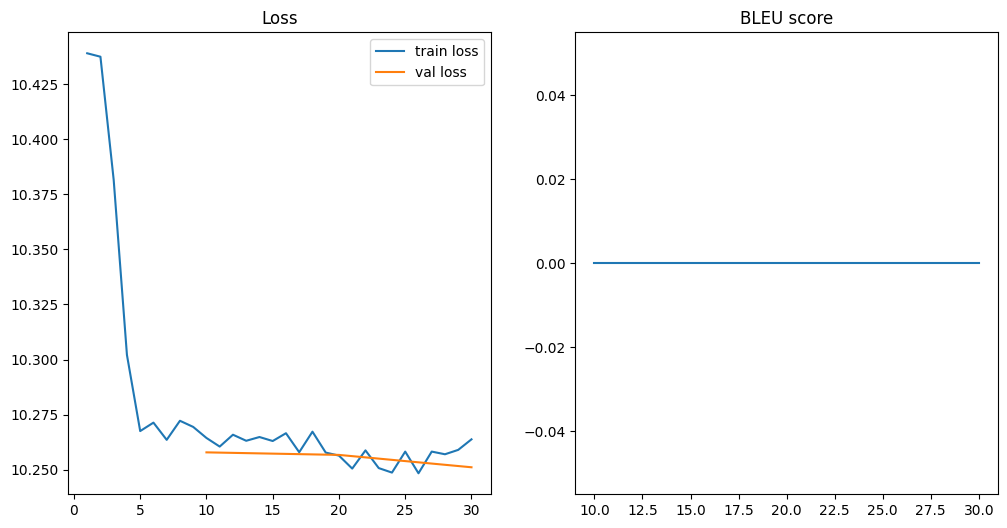

Mean loss=10.255


  0%|          | 39/10000 [31:14<132:58:32, 48.06s/it]


KeyboardInterrupt: 

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
batch_size = 32

# Словарь для хранения метрик
metrics = {
    'train_loss': [],
    'train_step': [],
    'val_loss': [],
    'val_bleu': [],
    'val_step': [],
}


for _ in trange(10000):
    model.train()
    step = len(metrics['train_loss']) + 1

    # Берём случайные объекты для обучения
    batch_ix = np.random.randint(len(train_input), size=batch_size)
    batch_inp = encoder_tokenizer.to_matrix(train_input[batch_ix]).to(device)
    batch_out = decoder_tokenizer.to_matrix(train_output[batch_ix]).to(device)

    loss_t = compute_loss(model, batch_inp, batch_out)

    optimizer.zero_grad()

    loss_t.backward()

    optimizer.step()

    metrics['train_step'].append(step)
    metrics['train_loss'].append(loss_t.item())

    # Считаем метрики валидации каждые 10 батчей обучения
    if step % 10 == 0:
        model.eval()

        val_subset = np.random.randint(len(val_output), size=256)
        val_batch_inp = encoder_tokenizer.to_matrix(val_input[val_subset]).to(device)
        val_batch_out = decoder_tokenizer.to_matrix(val_output[val_subset]).to(device)

        metrics['val_step'].append(step)
        metrics['val_loss'].append(compute_loss(model, val_batch_inp, val_batch_out).item())

        translator = Translator(
            transformer=model,
            encoder_tokenizer=encoder_tokenizer,
            decoder_tokenizer=decoder_tokenizer,
            dec_start_token_id=decoder_tokenizer.bos_ix,
            max_seq_len=40
        )

        # Чистим тексты для подсчёта BLEU score
        refrences = [[re.findall(pattern=regex, string=s.lower(),)] for s in val_output[val_subset]]
        translation = translator(val_input[val_subset])
        translation = [re.findall(pattern=regex, string=s.lower(),) for s in translation]

        metrics['val_bleu'].append(corpus_bleu(refrences, translation) * 100)

        # Визуализируем метрики
        clear_output(True)
        f, (ax1, ax2) = plt.subplots(1, 2)
        f.set_figheight(6)
        f.set_figwidth(12)
        ax1.plot(metrics['train_step'], metrics['train_loss'], label='train loss')
        ax1.plot(metrics['val_step'], metrics['val_loss'], label='val loss')
        ax1.set_title('Loss')
        ax1.legend()
        ax2.plot(metrics['val_step'], metrics['val_bleu'])
        ax2.set_title('BLEU score')
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:]), flush=True)



In [ ]:
print('Вы успешно справились с заданием: ', corpus_bleu(refrences, translation) * 100 > 28.0)

Посмотрим на примеры предсказаний модели из последнего батча валидации

In [ ]:
for i in np.random.randint(len(refrences), size=3):

    eng_sent = val_input[val_subset].values[i]
    model_translation = ' '.join(translation[i])
    true_translation = ' '.join(refrences[i][0])

    print(f'Предложение на английском: \n{eng_sent}\n')

    print(f'model_translation: {model_translation}')
    print(f'true_translation: {true_translation}\n\n')


## Что можно улучшить?

Чтобы улучшить результат, можно:
1. Использовать разные стратегии пост обработки ([beam search](https://arxiv.org/pdf/1702.01806));
2. Скачать предобученный трансформер, например, на [huggingface](https://huggingface.co/);
3. Попробовать другую комбинацию размерностей и количества голов в трансформере, например, попробовать его упростить;
4. Попробовать другие гиперпараметры обучения, например, более хитрое расписание для шага обучения, в оригинальной статье использовали вот такую формулу:

   $$\text{lrate} = d_{\text{model}}^{-0.5} \times \min(\text{step\_num}^{-0.5}, \text{step\_num} \times \text{warmup\_steps}^{-1.5}) $$


# Поздравляем

Вы проделали большой путь, реализовав свой собственный трансформер для задачи перевода:
1. Вы разобрались с позиционным кодированием;
2. Реализовали слой Multi-Head Attention;
3. Собрали из отдельных слоёв архитектуру;
4. Обучили свой трансформер для перевода с английского на русский язык.

В индустрии скорее всего вы будете работать с предобученными моделями. Такая, более практическая работа появится и в нашем курсе. Но даже сейчас, пройдя это задание, вы без труда разберётесь с тем, как использовать внешние модели для решения своих задач.